In [69]:
import os
import hashlib
import requests
import zipfile
import tarfile
import matplotlib.pyplot as plt
import collections
import torch
from torch.utils import data
import numpy as np

## 下载和预处理数据集

In [49]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [50]:
def download_dataset(name, cache_dir=None):
    """下载一个DATA_HUB中的文件,返回本地文件名"""
    assert name in DATA_HUB, f"{name} not in {DATA_HUB}"
    cache_dir = os.path.join('..', 'data') if cache_dir is None else cache_dir
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
            if sha1.hexdigest() == sha1_hash:
                return fname
    print(f"Downloading {name} from {url} to {fname}...")
    raw_data = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(raw_data.content)
    return fname


In [51]:
def download_dataset_and_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download_dataset(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    match ext:
        case '.zip':
            fp = zipfile.ZipFile(fname, 'r')
        case '.tar', '.gz':
            fp = tarfile.open(fname, 'r')
        case _:
            assert False, f'不支持的文件类型：{ext}'
    fp.extractall(path=base_dir)
    fp.close()
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all_datasets():
    """下载DATA_HUB中的所有数据集"""
    for name in DATA_HUB:
        download_dataset(name)
    

In [52]:
DATA_HUB['fra-eng'] = (DATA_URL + 'fra-eng.zip',
                       '94646ad1522d915e7b0f9296181140edcf86a4f5')

In [53]:
def read_data_nmt():
    """载入'英语-法语'数据集"""
    data_dir = download_dataset_and_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()
raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [54]:
def preprocess_nmt(text):
    """预处理'英语-法语'数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    ## 使用空格替换不间断空格，使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    ## 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i-1]) else char for i, char in enumerate(text)]
    return ''.join(out)
text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [55]:
## 词元化

In [56]:
def tokenize_nmt(text, num_examples=None):
    """词元化'英语-法语'数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target
source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

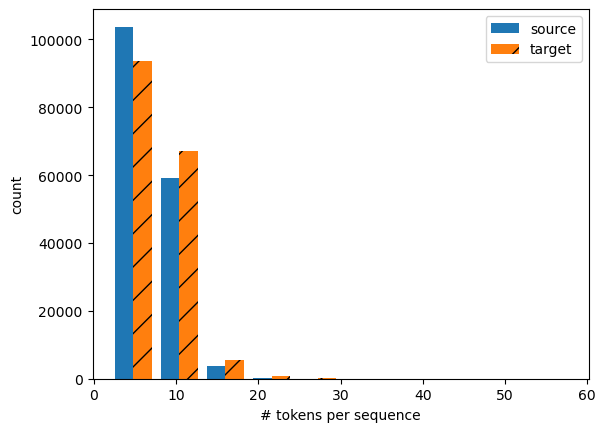

In [57]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    _, _, patches = plt.hist(
        [[len(l) for l in xlist],
        [len(l) for l in ylist]]
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    plt.legend(legend)
show_list_len_pair_hist(['source', 'target'], '# tokens per sequence', 'count', source, target)

## 词表

In [58]:
class Vocab:
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        tokens = [] if tokens is None else tokens
        reserved_tokens = [] if reserved_tokens is None else reserved_tokens
        ## 按出现频率排序
        counter = Vocab.count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.idx2token = ['<unk>'] + reserved_tokens
        self.token2idx = {token: idx for idx, token in enumerate(self.idx2token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token2idx:
                self.idx2token.append(token)
                self.token2idx[token] = len(self.idx2token)-1
    def __len__(self):
        return len(self.idx2token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token2idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx2token[indices]
        return [self.idx2token[index] for index in indices]
    @property
    def unk(self):
        return 0
    @property
    def token_freqs(self):
        return self._token_freqs 
    @staticmethod
    def count_corpus(tokens):
        """统计词元频率"""
        if isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        return collections.Counter(tokens)
  

In [59]:
src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [60]:
## 加载数据集

In [61]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token]*(num_steps-len(line))
tokens_seq1 = truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])
tokens_seq2 = src_vocab.to_tokens(tokens_seq1)
tokens_seq1, tokens_seq2

([47, 4, 1, 1, 1, 1, 1, 1, 1, 1],
 ['go',
  '.',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'])

In [62]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor(
        [truncate_pad(l, num_steps, vocab['<pad>']) for l in lines]
    )
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len


## 训练模型 

In [63]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train)

In [64]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_arrat, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_arrat, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size=batch_size)
    return data_iter, src_vocab, tgt_vocab

In [74]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X: ', X.type(torch.int32))
    print('X的有效长度: ', X_valid_len)
    print('X[0]的文本序列: ', src_vocab.to_tokens(list(X[0].type(torch.int32))))
    print('Y: ', Y.type(torch.int32))
    print('Y的有效长度: ', Y_valid_len)
    print('Y[0]的文本序列: ', src_vocab.to_tokens(list(Y[0].type(torch.int32))))
    break

X:  tensor([[40,  0,  5,  3,  1,  1,  1,  1],
        [52,  0,  4,  3,  1,  1,  1,  1]], dtype=torch.int32)
X的有效长度:  tensor([4, 4])
X[0]的文本序列:  ['how', '<unk>', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>']
Y:  tensor([[52, 13,  0,  5,  3,  1,  1,  1],
        [30,  0, 22,  5,  3,  1,  1,  1]], dtype=torch.int32)
Y的有效长度:  tensor([5, 5])
Y[0]的文本序列:  ["don't", 'get', '<unk>', '!', '<eos>', '<pad>', '<pad>', '<pad>']


## Exercises

1. 在load_data_nmt函数中尝试不同的num_examples参数值。这对源语言和目标语言的词表大小有何影响？

2. 某些语言（例如中文和日语）的文本没有单词边界指示符（例如空格）。对于这种情况，单词级词元化仍然是个好主意吗？为什么？